In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import h5py
import os
import illustris_python as il

#### Halo selection criteria

In [2]:
halo_min_log = 10. # lower mass limit of halo

### define paths and fields of interest

In [3]:
basePath = './fof_subhalo_z0/'  ### groupcat data files are in basePath/groups_099/
halo_fields = ['GroupFirstSub','Group_M_Mean200'] ### Halo fields of interest. Options for halo mass: 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_M_Crit200', 'Group_M_Crit500'
subhalo_fields = ['SubhaloFlag','SubhaloMass','SubhaloGrNr','SubhaloMassInRadType','SubhaloGasMetalFractions'] ### Subhalo fields. 'SubhaloMassInRadType' OR 'SubhaloMassInHalfRadType'
HI_column = 'm_hi_GD14_map' ### column of HI mass used; options are: 'm_hi_GD14_map', 'm_hi_GD14_vol', 'm_hi_GK11_map', 'm_hi_GK11_vol', 'm_hi_K13_map', 'm_hi_K13_vol', 'm_hi_L08_map', 'm_hi_S14_map', 'm_hi_S14_vol'

### load data for haloes and subhaloes

In [4]:
halos = il.groupcat.loadHalos(basePath,99,fields=halo_fields)
halos_id = np.arange(halos['count'])
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=subhalo_fields)
h = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
f_h1h2 = h5py.File('hih2_galaxy_099.hdf5','r')

### Get IDs of primary subhaloes from the gas supplementary catalog
#### then return the HI mass of those primary (central) subhaloes

In [5]:
flag = np.array(f_h1h2['is_primary'])
id_gas = np.array(f_h1h2['id_subhalo']).astype(np.int32)
id_gas_p = np.array(id_gas[np.where(flag==1.0)]).astype(np.int32)
m_h1_p = np.array(f_h1h2[HI_column][np.where(flag==1.0)]).astype(np.int32)

#### proceed to select the primary subhaloes in the `subhalos` array 

In [6]:
sub_id = subhalos['SubhaloGrNr'][id_gas_p]
sub_tot_mass = subhalos['SubhaloMass'][id_gas_p]
sub_mass_rad = subhalos['SubhaloMassInRadType'][id_gas_p]

#### perform a cross-match between the primary subhaloes and their parent haloes

In [7]:
subhalos_matched_ids, ind_halo, ind_sub = np.intersect1d(np.array(halos_id),np.array(sub_id), return_indices=True)
print('Number of central subhaloes with HI mass: %d' %subhalos_matched_ids.size)

Number of central subhaloes with HI mass: 27869


#### return respective masses of the central (primary) subhaloes

In [8]:
gal_mass_hi = m_h1_p[ind_sub]
gal_tot_mass = sub_tot_mass[ind_sub]
gal_mass_rad = sub_mass_rad[ind_sub]

#### convert masses in to adequate units

In [9]:
gal_mass_gas  = gal_mass_rad[:,0] * 1e10 / h
gal_mass_dm   = gal_mass_rad[:,1] * 1e10 / h               # total mass of all DM particles in the subhalo
gal_mass_star = gal_mass_rad[:,4] * 1e10 / h
halo_m200 = halos['Group_M_Mean200'][ind_halo] * 1e10 / h  # M200 of parent halo

###### (Note: 0 = gas, 1 = DM, 2 unused, 3 = tracers, 4 = stars, 5 = BHs)

### Apply halo selection criteria

In [10]:
halo_mass_min = 10**halo_min_log
gal_mass_star = gal_mass_star[halo_m200>halo_mass_min]
gal_mass_dm = gal_mass_dm[halo_m200>halo_mass_min]
gal_mass_gas = gal_mass_gas[halo_m200>halo_mass_min]
gal_mass_hi = gal_mass_hi[halo_m200>halo_mass_min]
halo_m200 = halo_m200[halo_m200>halo_mass_min]

#### select desired/adequate masses for components (especially for DM)

In [11]:
smass  = gal_mass_star  # stellar mass
gmass  = gal_mass_hi    # gas mass
dmmass = halo_m200      # DM halo mass

<ipython-input-12-cffec8ec442e>:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(smass), np.log10(gmass/dmmass), s=10)
<ipython-input-12-cffec8ec442e>:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(smass), np.log10(gmass/dmmass), s=10)


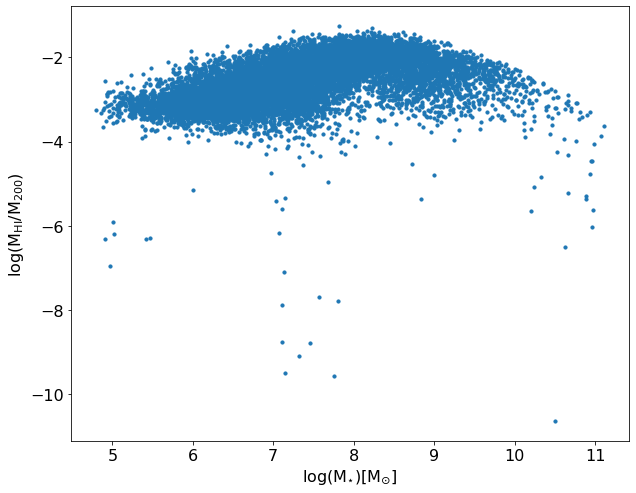

In [12]:
plt.rc('font', size=16)
plt.figure(figsize=(10,8))
plt.scatter(np.log10(smass), np.log10(gmass/dmmass), s=10)
plt.xlabel(r'$\rm log(M_{\star})[M_{\odot}]$')
plt.ylabel(r'$\rm log(M_{\rm HI}/M_{\rm 200})$');

### Test with all central galaxies from the simulation
#### (no x-match with gas supplementary table -- note Mgas instead of MHI)

In [13]:
ids,i,j = np.intersect1d(halos_id, np.array(subhalos['SubhaloGrNr']), return_indices=True)

In [14]:
mhalo = halos['Group_M_Mean200'][i] * 1e10/h
msub = subhalos['SubhaloMassInRadType'][j] * 1e10/h
gas_m_frac = subhalos['SubhaloGasMetalFractions'][j]

In [15]:
m_200 = mhalo[mhalo>halo_mass_min]
m_sub = msub[mhalo>halo_mass_min]
gas_frac = gas_m_frac[mhalo>halo_mass_min]

#### deriving the HI mass from the gas mass
##### MHI = H_fraction * Mgas

In [16]:
mgas, mstar = m_sub[:,0], m_sub[:,4]
mhi = gas_frac[:,0] * mgas

###### Note from simulation regarding H_fraction: Individual abundances: H, He, C, N, O, Ne, Mg, Si, Fe, total (in this order). Each is the dimensionless ratio of the total mass in that species divided by the total gas mass, both restricted to gas cells within twice the stellar half mass radius. The tenth entry contains the 'total' of all other (i.e. untracked) metals.

<ipython-input-17-0c777eee13bb>:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(mstar),np.log10(mhi/m_200), s=10)


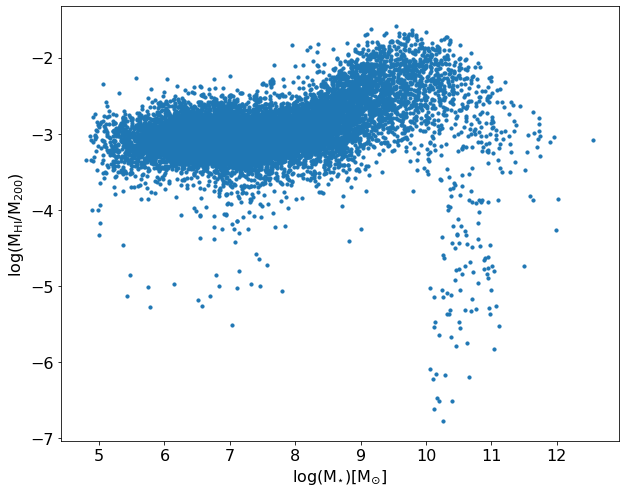

In [17]:
plt.rc('font', size=16)
plt.figure(figsize=(10,8))
plt.scatter(np.log10(mstar),np.log10(mhi/m_200), s=10)
plt.xlabel(r'$\rm log(M_{\star})[M_{\odot}]$')
plt.ylabel(r'$\rm log(M_{\rm HI}/M_{\rm 200})$');